#### 重复文章代码
##### ref: M.S. Anwar, et al., Stability of synchronization in simplicial complexes with multiple interaction layers, Phys. Rev. E 106 (2022) 034314. https://doi.org/10.1103/PhysRevE.106.034314.


In [145]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import os

seed = 0
np.random.seed(seed)

#### 模型构建

In [146]:
# Sherman 神经元模型 (spiking bursting)
@njit
def sherman_model(vars, t, I):
    res = np.zeros_like(vars)

    V, n, s = vars

    # Sherman model parameters
    g_Ca = 3.6      # Calcium conductance
    g_K = 10.       # Potassium conductance
    g_s = 4.        # slow potassium conductance

    E_Ca = .025     # Calcium reversal potential
    E_K = -0.075    # Potassium reversal potential

    tau = .02       # Time constant
    tau_s = 5.      # Time constant for slow potassium
    mu = 1.0        # scaling factor

    m_inf = 1.0 / (1.0 + np.exp(-(V + 0.02) * 83.34))  # steady state activation for fast potassium
    n_inf = 1.0 / (1.0 + np.exp(-(V + 0.016) * 178.57))  # steady state activation for slow potassium
    s_inf = 1.0 / (1.0 + np.exp(-(V + 0.035345) * 100.))  # steady state activation for calcium

    I_s = g_s * s * (V - E_K)  # slow potassium current
    I_K = g_K * n * (V - E_K)  # fast potassium current
    I_Ca = g_Ca * m_inf * (V - E_Ca)   # calcium current

    dV_dt = (- I_K - I_s - I_Ca + I[0]) / tau      # voltage equation
    dn_dt = ((n_inf - n) * mu + I[1])/ tau               # fast potassium activation equation
    ds_dt = (s_inf - s + I[2]) / tau_s                  # slow potassium activation equation

    res[0] = dV_dt
    res[1] = dn_dt
    res[2] = ds_dt

    return res

In [147]:
@njit
def RK4(fun, x0, t, dt, *args):
    """
    使用 Runge-Kutta 方法计算一个时间步后系统的状态。
    args:
        fun: 微分方程
        x0: 上一个时间单位的状态变量
        t: 运行时间
        dt: 时间步长
    :return:
        x0 (numpy.ndarray): 下一个时间单位的状态变量
    """
    k1 = fun(x0, t, *args)
    k2 = fun(x0 + (dt / 2.) * k1, t + (dt / 2.), *args)
    k3 = fun(x0 + (dt / 2.) * k2, t + (dt / 2.), *args)
    k4 = fun(x0 + dt * k3, t + dt, *args)

    x0 += (dt / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)

    return x0

In [148]:
# 测试模型
N = 3
dt = 0.001
t = 0.
N_vars = 3
vars = np.random.rand(N_vars, N)

for i in range(50_000):
    I = np.zeros((N_vars, N))
    RK4(sherman_model, vars, t, dt, I)

mem = []
for i in range(40_000):
    I = np.zeros((N_vars, N))
    RK4(sherman_model, vars, t, dt, I)

    mem.append(vars[0].copy())

    t += dt

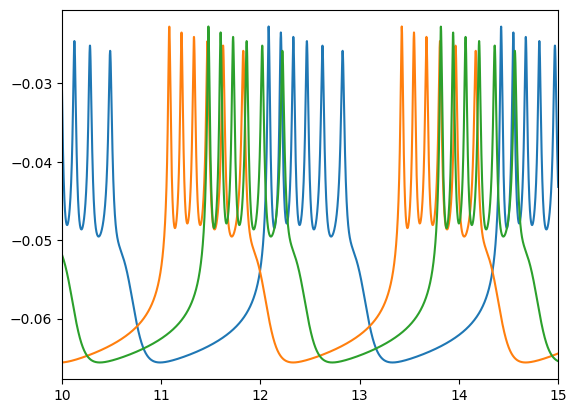

In [149]:
plt.plot(np.arange(len(mem)) * dt, mem)
plt.xlim(10,15)
plt.show()

In [150]:
# 突触模型构建
## 电突触
@njit
def syn_electr(V_pre, V_post, pre_ids, post_ids, w):
    """
    突触电流模型
        V_pre:    前神经元的膜电位
        V_post:   后神经元的膜电位
        pre_ids:  前神经元的id
        post_ids: 后神经元的id
        weights:  突触权重
    """
    vj_vi = V_pre[pre_ids] - V_post[post_ids]

    currents = w * vj_vi

    N_neurons = len(V_post)
    
    Isyn = np.bincount(post_ids, weights=currents, minlength=N_neurons)

    return Isyn

@njit
def syn_electr_2D(V_pre1, V_pre2, V_post, pre_ids1, pre_ids2, post_ids, w):
    """
    突触电流模型
        V_pre1:    前神经元的膜电位
        V_pre2:    前神经元的膜电位
        V_post:    后神经元的膜电位
        pre_ids1:  前神经元的id1
        pre_ids2:  前神经元的id2
        post_ids:  后神经元的id
        weights:   突触权重
    """
    vj_vk_vi = V_pre1[pre_ids1] + V_pre2[pre_ids2] - 2 * V_post[post_ids]

    currents = w * vj_vk_vi

    N_neurons = len(V_post)
    
    Isyn = np.bincount(post_ids, weights=currents, minlength=N_neurons)

    return Isyn

## 化学突触
@njit
def syn_chem(V_pre, V_post, pre_ids, post_ids, w):
    """
    突触电流模型
        V_pre:    前神经元的膜电位
        V_post:   后神经元的膜电位
        pre_ids:  前神经元的id
        post_ids: 后神经元的id
        weights:  突触权重
    """
    s = 1.0 / (1.0 + np.exp(-(V_pre + 0.045) * 1000.))  # steady state activation for calcium

    currents = w * s[pre_ids] * (-0.02 - V_post[post_ids])

    N_neurons = len(V_post)
    
    Isyn = np.bincount(post_ids, weights=currents, minlength=N_neurons)

    return Isyn

@njit
def syn_chem_2D(V_pre1, V_pre2, V_post, pre_ids1, pre_ids2, post_ids, w):
    """
    突触电流模型
        V_pre1:    前神经元的膜电位
        V_pre2:    前神经元的膜电位
        V_post:    后神经元的膜电位
        pre_ids1:  前神经元的id1
        pre_ids2:  前神经元的id2
        post_ids:  后神经元的id
        weights:   突触权重
    """
    s = 1.0 / (1.0 + np.exp(-(V_pre1 + 0.045) * 1000.))  
    s2 = 1.0 / (1.0 + np.exp(-(V_pre2 + 0.045) * 1000.))  
    
    currents = w * (s[pre_ids1] + s2[pre_ids2]) * (-0.02 - V_post[post_ids])

    N_neurons = len(V_post)

    Isyn = np.bincount(post_ids, weights=currents, minlength=N_neurons)

    return Isyn


In [151]:
# 计算同步
@njit
def sync_e(vars, T_time, N):
    """
    计算同步
        E: 同步误差
        vars: 变量
        T_time: 时间
        N: 节点数      
    """
    temp = vars[:, None] - vars

    temp = np.abs(temp).sum() / (N * (N-1) * T_time)
    # temp = np.linalg.norm(temp) / (N * (N-1) * T_time)

    return temp

#### 高阶交互的矩阵表示
一阶交互中的所有三角形全部组成二阶交互作用

In [152]:
# 构建小世界网络
@njit
def create_sw_jit(n, k, p, seed=None):
    """
    使用 numba 加速创建小世界网络的连接矩阵(双向)
    
    参数:
        n (int): 网络中的节点数
        k (int): 每个节点的初始平均度数（必须为偶数）
        p (float): 重连概率（0到1之间）
        seed (int): 随机数种子
        
    返回:
        np.ndarray: 小世界网络的连接矩阵
    """
    if seed is not None:
        np.random.seed(seed)
    # 创建一个环形网络
    matrix = np.zeros((n, n), dtype=np.int32)
    for i in range(n):
        for j in range(1, k // 2 + 1):
            matrix[i, (i + j) % n] = 1
            matrix[i, (i - j) % n] = 1

    # 重连部分连接
    for i in range(n):
        for j in range(1, k // 2 + 1):
            if np.random.rand() < p:
                # 找到一个合适的新邻居，确保不是自己，也不是当前的邻居
                current_neighbor = (i + j) % n
                available = []
                for x in range(n):
                    if x != i and matrix[i, x] == 0:
                        available.append(x)
                
                if len(available) > 0:  # 确保还有可用的节点进行重连
                    new_neighbor = available[np.random.randint(0, len(available))]
                    # 断开原有连接
                    matrix[i, current_neighbor] = 0
                    matrix[current_neighbor, i] = 0
                    # 建立新的连接
                    matrix[i, new_neighbor] = 1
                    matrix[new_neighbor, i] = 1

    return matrix

@njit
def generate_regular_graph(n, k, seed=None):
    """
    生成一个n个节点，每个节点入度为k的随机有向图，并生成其邻接矩阵。
    
    参数:
    n: 节点数量
    k: 每个节点的入度
    
    返回:
    adj_matrix: 随机化后的邻接矩阵
    """
    # 检查k的合理性
    if k >= n:
        raise ValueError("k must be less than n")
    # 设置随机种子
    if seed is not None:
        np.random.seed(seed)
    
    # 初始化邻接矩阵
    adj_matrix = np.zeros((n, n), dtype=np.int32)
    
    # Step 1: 循环为每个节点选择入度为k的目标节点
    for i in range(n):
        # 创建可用节点列表（排除自己）
        available_nodes = np.zeros(n - 1, dtype=np.int32)
        index = 0
        for j in range(n):
            if j != i:
                available_nodes[index] = j
                index += 1
        
        # 检查剩余节点数量是否足够
        if len(available_nodes) < k:
            raise ValueError(f"Not enough available nodes for node {i}.")
        
        # 随机选择k个目标节点
        neighbors = np.random.choice(available_nodes, k, replace=False)
        
        # 更新邻接矩阵
        for neighbor in neighbors:
            adj_matrix[i, neighbor] = 1  # 设置单向连接
    
    # 验证每个节点的入度是否符合要求
    for i in range(n):
        if np.sum(adj_matrix[i]) != k:
            raise ValueError(f"Node {i} has inin-degree {np.sum(adj_matrix[i])}, expected {k}.")
    
    return adj_matrix

In [153]:
# 构建高阶网络(二阶，三维矩阵)
## 找出一级交互中的所有三角形
@njit
def find_triangles(adjacency_matrix):
    """
    找到给定邻接矩阵中的所有三角形。
    
    参数:
        adjacency_matrix (np.ndarray): 邻接矩阵
    
    返回:
        list: 三角形的列表，每个三角形由三个节点组成
    """
    n = adjacency_matrix.shape[0]
    triangles = []
    for i in range(n):
        for j in range(i + 1, n):
            if adjacency_matrix[i, j] == 1:
                for k in range(j + 1, n):
                    if adjacency_matrix[i, k] == 1 and adjacency_matrix[j, k] == 1:
                        triangles.append((i, j, k))
    return triangles

## 构建二阶高阶网络
@njit
def build_second_order_network(N, triangles):
    """
    构建二阶网络。
    参数:
        N (int): 网络中节点的数量
        triangles (list): 三角形的列表

    返回:
        np.ndarray: 二阶网络的连接矩阵(post, pre1, pre2)
    """
    # 创建一个三维矩阵，大小为 (N, N, N)，用于存储二阶网络的连接关系
    second_order_network = np.zeros((N, N, N), dtype=np.int32)

    for index, (i, j, k) in enumerate(triangles):
        second_order_network[i, j, k] = 1
        second_order_network[i, k, j] = 1
        second_order_network[j, i, k] = 1
        second_order_network[j, k, i] = 1
        second_order_network[k, i, j] = 1
        second_order_network[k, j, i] = 1

    return second_order_network

## 降维高阶网络
@njit
def create_triangle_count_matrix(N, triangles):
    """
    创建一个二阶网络的三角形计数矩阵。
    
    参数:
        N (int): 网络中节点的数量
        triangles (list): 三角形的列表
    
    返回:
        np.ndarray: 二阶网络的三角形计数矩阵
    """
    triangle_count_matrix = np.zeros((N, N), dtype=np.int32)
    for index, (i, j, k) in enumerate(triangles):
        triangle_count_matrix[i, j] += 1
        triangle_count_matrix[j, i] += 1
        triangle_count_matrix[i, k] += 1
        triangle_count_matrix[k, i] += 1
        triangle_count_matrix[j, k] += 1
        triangle_count_matrix[k, j] += 1

    return triangle_count_matrix 

In [154]:
# 稀疏矩阵
## 稀疏二维矩阵
@njit
def matrix_to_sparse(conn, weight_matrix=None):
    """
    将矩阵转换为稀疏矩阵
  
        参数：
        - conn: 连接矩阵(二元矩阵)
        - weight_matrix: 权重矩阵(可选)
    
        返回：
        - pre_ids   : 前节点的id
        - post_ids  : 后节点的id
        - weights   : 节点对的权重
    """
    # 将 conn 转换为二元矩阵
    binary_conn = np.where(conn != 0, 1, 0)
  
    # 如果未提供权重矩阵，则默认为全1矩阵
    if weight_matrix is None:
        weight = np.ones_like(conn, dtype=np.float64)
    else:
        weight = np.asarray(weight_matrix, dtype=np.float64)

    # 确保 binary_conn 和 weight_matrix 形状一致
    if binary_conn.shape != weight.shape:
        raise ValueError("binary_conn 和 weight_matrix 的形状必须一致！")
  
    # 提取非零元素的行列索引
    post_ids, pre_ids = np.nonzero(binary_conn)

    # 提取对应权重
    rows, cols = weight.shape
    indices =  post_ids * rows + pre_ids  # 计算一维索引
    weights = weight.ravel()[indices]  # 一维索引提取权重

    # 将结果整合为一个三列矩阵
    # ids_and_weights = np.vstack((pre_ids, post_ids, weights))

    return pre_ids, post_ids, weights

# 稀疏三维矩阵
@njit
def matrix_to_sparse_3d(conn, weight_matrix=None):
    """
    将三维矩阵转换为稀疏矩阵
    
    参数:
        conn (np.ndarray): 三维连接矩阵
        weight_matrix (np.ndarray): 权重矩阵(可选)
    
    返回:
        tuple: 稀疏矩阵的行索引、列索引和权重
    """
    # 将 conn 转换为二元矩阵
    binary_conn = np.where(conn != 0, 1, 0)
  
    # 如果未提供权重矩阵，则默认为全1矩阵
    if weight_matrix is None:
        weight = np.ones_like(conn, dtype=np.float64)
    else:
        weight = np.asarray(weight_matrix, dtype=np.float64)

    # 确保 binary_conn 和 weight_matrix 形状一致
    if binary_conn.shape != weight.shape:
        raise ValueError("binary_conn 和 weight_matrix 的形状必须一致！")
  
    # 提取非零元素的行列索引
    post_ids, pre_ids, pre2_ids = np.nonzero(binary_conn)

    # 提取对应权重
    rows, cols, depth = weight.shape
    indices = post_ids * rows * cols + pre_ids * cols + pre2_ids
    weights = weight.ravel()[indices]  # 一维索引提取权重
    # 将结果整合为一个三列矩阵
    # ids_and_weights = np.vstack((pre_ids, pre2_ids, post_ids, weights))

    return pre_ids, pre2_ids, post_ids, weights

#### 开始模拟

In [155]:
N = 200
k_SW = 4
k_c= 4
P_SW = 0.15
dt = 0.001

In [156]:
# 创建图
## 第一层(一阶 和 二阶) 电
A1 = create_sw_jit(N, k_SW, P_SW, seed=seed)
# A1 = np.ones((N, N), dtype=np.int32) - np.eye(N, dtype=np.int32) # 完全图
pre_ids_1, post_ids_1, weights_1 = matrix_to_sparse(A1) # 稀疏化
triangles_1 = find_triangles(A1)
A1_2 = build_second_order_network(N, triangles_1)
pre1_ids_12, pre2_ids_12, post_ids_12, weights_12 = matrix_to_sparse_3d(A1_2) # 稀疏化

## 第二层(一阶 和 二阶) 化学
A2 = generate_regular_graph(N, k_c, seed=seed)
# A2 = np.ones((N, N), dtype=np.int32) - np.eye(N, dtype=np.int32) # 完全图
pre_ids_2, post_ids_2, weights_2 = matrix_to_sparse(A2) # 稀疏化
triangles_2 = find_triangles(A2)
A2_2 = build_second_order_network(N, triangles_2)
pre1_ids_22, pre2_ids_22, post_ids_22, weights_22 = matrix_to_sparse_3d(A2_2) # 稀疏化


In [157]:
# 初始化节点模型
N_vars = 3
vars_nodes = np.ones((N_vars, N))*0.01
t = 0.

g_e = 3.4
g_c = 0.0
g_SI = 0.1

In [158]:
# 循环主体
for i in range(40_000):
    I = np.zeros((N_vars, N))
    RK4(sherman_model, vars_nodes, t, dt, I)


vars_nodes[0] += np.random.rand(N)
for i in range(100_000):
    I = np.zeros((N_vars, N))

    # 计算突触电流
    Isyn_1 = syn_electr(vars_nodes[0], vars_nodes[0], pre_ids_1, post_ids_1, g_e)
    Isyn_2 = syn_chem(vars_nodes[0], vars_nodes[0], pre_ids_2, post_ids_2, g_c)
    Isyn_12 = syn_electr_2D(vars_nodes[0], vars_nodes[0], vars_nodes[0], pre1_ids_12, pre2_ids_12, post_ids_12, g_SI)
    # Isyn_22 = syn_chem_2D(vars_nodes[0], vars_nodes[0], vars_nodes[0], pre1_ids_22, pre2_ids_22, post_ids_22, g_SI)

    # 计算突触电流
    I[0] += Isyn_1 + Isyn_2 + Isyn_12
    # I[0] = Isyn_1 + Isyn_2 + Isyn_22
    
    RK4(sherman_model, vars_nodes, t, dt, I)

E = 0.0

mem = []

T_n = 50_000
for i in range(T_n):
    I = np.zeros((N_vars, N))

    # 计算突触电流
    Isyn_1 = syn_electr(vars_nodes[0], vars_nodes[0], pre_ids_1, post_ids_1, g_e)
    Isyn_2 = syn_chem(vars_nodes[0], vars_nodes[0], pre_ids_2, post_ids_2, g_c)
    Isyn_12 = syn_electr_2D(vars_nodes[0], vars_nodes[0], vars_nodes[0], pre1_ids_12, pre2_ids_12, post_ids_12, g_SI)
    # Isyn_22 = syn_chem_2D(vars_nodes[0], vars_nodes[0], vars_nodes[0], pre1_ids_22, pre2_ids_22, post_ids_22, g_SI)

    # 计算突触电流
    I[0] += Isyn_1 + Isyn_2 + Isyn_12
    # I[0] = Isyn_1 + Isyn_2 + Isyn_22

    RK4(sherman_model, vars_nodes, t, dt, I)

    t += dt

    mem.append(vars_nodes[0].copy())

    # 计算同步
    E += sync_e(vars_nodes[0], T_n, N)


In [159]:
E

9.359007065540352e-06

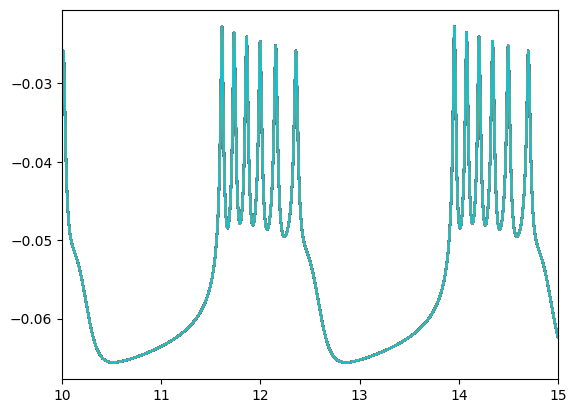

In [160]:
plt.plot(np.arange(len(mem)) * dt, mem)
plt.xlim(10,15)
plt.show()